# Get simulation results. 

This notebook automatically collect and plot accuracy vs numlabels graphs for best and latest models for `efficientnet-lite0` and `unet` networks. Results are saved as `PNG` images.

## 1) Imports.

In [34]:
# Utility imports
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import os
from glob import glob
import sys
sys.path.append("..")

# Main imports
import torch
import MSMatch as mm
from MSMatch.utils.load_cfg import load_cfg
from termcolor import colored
plt.rcParams['figure.figsize'] = [10, 10]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
simulation_path="./saved_models/test"
dataset="eurosat_rgb"

## 2) Getting configurations

In [36]:
print("Parsing simulation dir: "+colored(os.path.join(simulation_path,dataset), "red"))
simulation_dirs=sorted(glob(os.path.join(simulation_path,dataset, "*")))
print("Number of tests found: ", colored(len(simulation_dirs), "red"))


Parsing simulation dir: ./saved_models/test/eurosat_rgb
Number of tests found:  6


## 3) Loading and testing trained models

In [43]:
# Creating empty dictionaries for best and latest models
simulation_points=[50,100,200]
unet_best=dict(zip(simulation_points, [0 for n in simulation_points]))
unet_latest=dict(zip(simulation_points, [0 for n in simulation_points]))
efficientnet_best=dict(zip(simulation_points, [0 for n in simulation_points]))
efficientnet_latest=dict(zip(simulation_points, [0 for n in simulation_points]))


# This variable is used to avoid to load the dataset if it has the same seed of the previous run.
last_seed=-1


#Testing trained models
for test, n in zip(simulation_dirs, range(len(simulation_dirs))):

    print(colored("\n--- Inspecting: "+simulation_dirs[n]+" ---", "blue"))

    #Loading dataset
    cfg=load_cfg(os.path.join(test, "cfg.toml"))
    
    if last_seed != cfg.seed:
        print("Loading dataset: "+colored(dataset,"green"))
        _eval_dset = mm.SSL_Dataset(name=dataset, train=False, data_dir=None, seed=cfg.seed,)
        eval_dset = _eval_dset.get_dset()
        eval_loader = mm.get_data_loader(eval_dset, 32, num_workers=1)
        last_seed=cfg.seed

    cfg.num_classes = _eval_dset.num_classes
    cfg.num_channels = _eval_dset.num_channels
    
    
    print("Loading model: "+colored(cfg.net,"red"))
    net_builder = mm.get_net_builder(cfg.net,pretrained=cfg.pretrained, in_channels=cfg.num_channels, scale=cfg.scale)
    net = net_builder(num_classes=cfg.num_classes, in_channels=cfg.num_channels)
    
    for model_type in ["latest_model.pth", "model_best.pth"]:
        print("Model type: "+colored(model_type, "cyan"))
        net.load_state_dict(torch.load(os.path.join(simulation_dirs[n], model_type))["eval_model"])
        if torch.cuda.is_available():
            net.cuda()
        net.eval() 
    
        acc = 0.0
        with torch.no_grad():
            for image, target in eval_loader:
                if torch.cuda.is_available():
                    image = image.type(torch.FloatTensor).cuda()
                logit = net(image)
    
                acc += logit.cpu().max(1)[1].eq(target).sum().numpy()
    
        acc=acc/len(eval_dset)
        print(f"Test Accuracy: {acc}")

        
        
        if cfg.net == "efficientnet-lite0":
            if model_type == "latest_model.pth":
                print( "efficientnet-lite0", "last", cfg.num_labels)
                efficientnet_latest[cfg.num_labels]=acc * 100
            else:
                efficientnet_best[cfg.num_labels]=acc * 100
                print( "efficientnet-lite0", "best", cfg.num_labels)
        else:
            if model_type == "latest_model.pth":
                unet_best[cfg.num_labels]=acc * 100
                print( "unet", "last", cfg.num_labels)
            else:
                unet_latest[cfg.num_labels]=acc * 100
                print( "unet", "best", cfg.num_labels)


--- Inspecting: ./saved_models/test/eurosat_rgb/FixMatch_archefficientnet-lite0_batch32_confidence0.95_lr0.01_uratio7_wd0.00075_wu1.0_seed42_numlabels100_optSGD ---
Loading dataset: eurosat_rgb


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


Loading model: efficientnet-lite0
Using not pretrained model efficientnet-lite0 ...
Model type: latest_model.pth
Test Accuracy: 0.8955555555555555
100
Model type: model_best.pth
Test Accuracy: 0.9381481481481482
100

--- Inspecting: ./saved_models/test/eurosat_rgb/FixMatch_archefficientnet-lite0_batch32_confidence0.95_lr0.01_uratio7_wd0.00075_wu1.0_seed42_numlabels200_optSGD ---
Loading model: efficientnet-lite0
Using not pretrained model efficientnet-lite0 ...
Model type: latest_model.pth
Test Accuracy: 0.9503703703703704
200
Model type: model_best.pth
Test Accuracy: 0.9574074074074074
200

--- Inspecting: ./saved_models/test/eurosat_rgb/FixMatch_archefficientnet-lite0_batch32_confidence0.95_lr0.01_uratio7_wd0.00075_wu1.0_seed42_numlabels50_optSGD ---
Loading model: efficientnet-lite0
Using not pretrained model efficientnet-lite0 ...
Model type: latest_model.pth
Test Accuracy: 0.8385185185185186
50
Model type: model_best.pth
Test Accuracy: 0.9044444444444445
50

--- Inspecting: ./save

## 4) Plotting models

### Best models

In [38]:
fig_best=plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

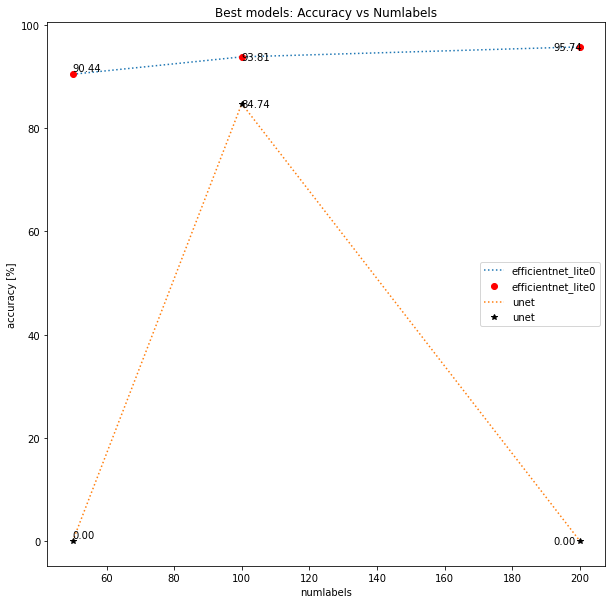

In [39]:
# Getting values from dictionary.
efficientnet_best_values=[efficientnet_best[x] for x in efficientnet_best.keys()]
unet_best_values=[unet_best[x] for x in unet_best.keys()]

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt_ef = plt.plot(simulation_points, efficientnet_best_values, linestyle=":")
stem_ef = plt.plot(simulation_points, efficientnet_best_values, 'ro')
plt_unet= plt.plot(simulation_points, unet_best_values, linestyle=":")
stem_unet = plt.plot(simulation_points, unet_best_values, 'k*')

 
for (x,n) in zip(efficientnet_best_values, range(len(efficientnet_best_values))): 
    if n==0:
        plt.annotate("{:.2f}".format(x), xy=(simulation_points[n], x), xytext=(simulation_points[n], x+0.55))
    elif n == len(efficientnet_best_values) - 1:
        plt.annotate("{:.2f}".format(x), xy=(simulation_points[n], x), xytext=(simulation_points[n]-8, x-0.55))
    else:
        plt.annotate("{:.2f}".format(x), xy=(simulation_points[n], x), xytext=(simulation_points[n], x-0.55))

for (x,n) in zip(unet_best_values, range(len(unet_best_values))): 
    if n==0:
        plt.annotate("{:.2f}".format(x), xy=(simulation_points[n], x), xytext=(simulation_points[n], x+0.55))
    elif n == len(unet_best_values) - 1:
        plt.annotate("{:.2f}".format(x), xy=(simulation_points[n], x), xytext=(simulation_points[n]-8, x-0.55))
    else:
        plt.annotate("{:.2f}".format(x), xy=(simulation_points[n], x), xytext=(simulation_points[n], x-0.55))

plt.xlabel("numlabels")
plt.ylabel('accuracy [%]')
plt.legend(["efficientnet_lite0", "efficientnet_lite0", "unet", 'unet'])
plt.title("Best models: Accuracy vs Numlabels")
plt.savefig("best.png")

### Latest models

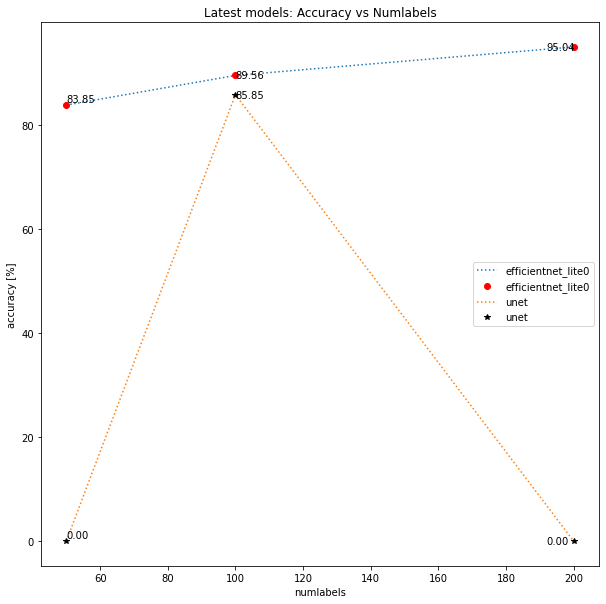

In [40]:
# Getting values from dictionary.
efficientnet_latest_values=[efficientnet_latest[x] for x in efficientnet_latest.keys()]
unet_latest_values=[unet_latest[x] for x in unet_latest.keys()]

plt.close()
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt_ef = plt.plot(simulation_points, efficientnet_latest_values, linestyle=":")
stem_ef = plt.plot(simulation_points, efficientnet_latest_values, 'ro')
plt_unet= plt.plot(simulation_points, unet_latest_values, linestyle=":")
stem_unet = plt.plot(simulation_points, unet_latest_values, 'k*')


for (x,n) in zip(efficientnet_latest_values, range(len(efficientnet_latest_values))): 
    if n==0:
        plt.annotate("{:.2f}".format(x), xy=(simulation_points[n], x), xytext=(simulation_points[n], x+0.55))
    elif n == len(efficientnet_latest_values) - 1:
        plt.annotate("{:.2f}".format(x), xy=(simulation_points[n], x), xytext=(simulation_points[n]-8, x-0.55))
    else:
        plt.annotate("{:.2f}".format(x), xy=(simulation_points[n], x), xytext=(simulation_points[n], x-0.55))

for (x,n) in zip(unet_latest_values, range(len(unet_latest_values))): 
    if n==0:
        plt.annotate("{:.2f}".format(x), xy=(simulation_points[n], x), xytext=(simulation_points[n], x+0.55))
    elif n == len(unet_latest_values) - 1:
        plt.annotate("{:.2f}".format(x), xy=(simulation_points[n], x), xytext=(simulation_points[n]-8, x-0.55))
    else:
        plt.annotate("{:.2f}".format(x), xy=(simulation_points[n], x), xytext=(simulation_points[n], x-0.55))

plt.xlabel("numlabels")
plt.ylabel('accuracy [%]')
plt.legend(["efficientnet_lite0", "efficientnet_lite0", "unet", 'unet'])
plt.title("Latest models: Accuracy vs Numlabels")
plt.savefig("latest.png")